Calculating SIFT descriptors. Number of images in dataset/food2/AngKuKueh is 190
Calculating SIFT descriptors. Number of images in dataset/food2/AisKacang is 187
Feature extration: 132.159981012 seconds
Number of words  (128, 542615)
('Training GMM of size', 64)
GMM: 60.9217488766 seconds
(128, 64)
(128, 64)
(64, 1)
Encoding FV
Fisher Vector: 227.583250046 seconds
Training SVM
(377,)
SVM: 0.663091897964 seconds


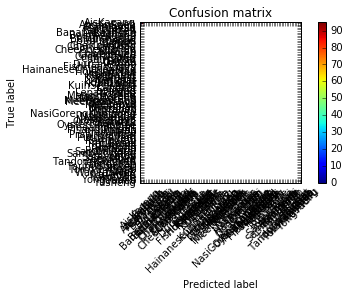

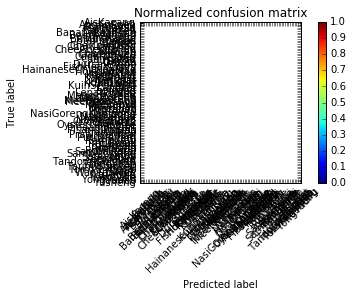

Score for fold  1 =  0.984126984127
SVM: 0.805048942566 seconds


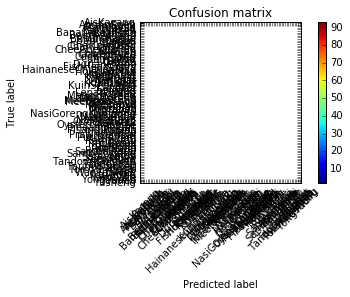

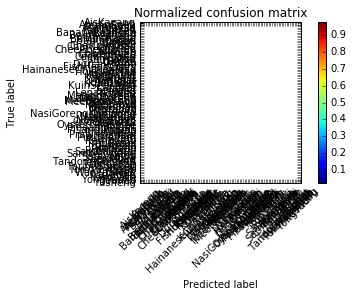

Score for fold  2 =  0.978723404255
Accuracy :  0.981425194191
Total: 433.404832125 seconds


In [3]:
#Author: Jacob Gildenblat, 2014
#License: you may use this for whatever you like 
import sys, glob, argparse
import matplotlib.pyplot as plt
import numpy as np
import math, cv2
import csv
import time
import pickle
import hickle as hkl

from scipy.stats import multivariate_normal
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from _vlfeat import *
from vl_phow import vl_phow

'''
def dictionary(descriptors, N):
    em = cv2.EM(N)
    em.train(descriptors)

    return np.float32(em.getMat("means")), \
        np.float32(em.getMatVector("covs")), np.float32(em.getMat("weights"))[0]
'''

def dictionary(descriptors, N):
    means, covs, priors, _ = vl_gmm(descriptors, N)
    #save("means.gmm", gmm.means_)
    #save("covs.gmm", gmm.covars_)
    #save("weights.gmm", gmm.weights_)
    return means, covs, priors 

def image_descriptors(file):
    img = cv2.imread(file, 0)
    #img = cv2.resize(img, (256, 256))
    img = np.array(img, 'f', order='F') # 'F' = column-major order!
    img = np.array(img, 'float32')

    f, descriptors = vl_sift(img,floatDescriptors=True, verbose=False) #0.7225 acc
    #descriptor = cv2.DescriptorExtractor_create("OpponentSURF")
    #_ , descriptors = cv2.SIFT().detectAndCompute(img, None)
    #descriptors = apply_pca(descriptors)
    #f, descriptors = vl_dsift(img, fast=False, norm=True, step=100, floatDescriptors=True, verbose=False, size=5) #0.33 acc
    #f, descriptors = vl_phow(img, verbose=False) #0.73125 128x128
    descriptors = np.swapaxes(descriptors,0,1)
    return descriptors

def folder_descriptors(folder):
    files = glob.glob(folder + "/*.jpg")
    print "Calculating SIFT descriptors. Number of images in "+ folder +" is " + str(len(files))
    return np.concatenate([image_descriptors(file) for file in files])

def fisher_vector(samples, means, covs, w):
    samples = np.swapaxes(samples,0,1)
    fv = vl_fisher(samples, means, covs, w, fast=True, improved=True)
    test = []
    
    for i in fv:
        test = np.append(test , i[0])
        
    return test

def apply_pca(image_descriptors):
    pca = PCA(n_components=64)
    return (pca.fit_transform(image_descriptors))

def generate_gmm(input_folder, N):
    loadfeature = False
    
    # start count execution time
    start_time = time.time()
    words = load_feature() if loadfeature else np.concatenate([folder_descriptors(folder) for folder in glob.glob(input_folder + '/*')]) 
    print("Feature extration: %s seconds" % (time.time() - start_time))
    
    hkl.dump(words, 'pca_feature.hkl', mode='w')
        
    words = np.swapaxes(words,0,1)
    print "Number of words ", words.shape
    print("Training GMM of size", N)
    start_time = time.time()
    means, covs, weights = dictionary(words, N)
    print("GMM: %s seconds" % (time.time() - start_time))
    
    print means.shape
    print covs.shape
    print weights.shape

    np.save("means.gmm", means)
    np.save("covs.gmm", covs)
    np.save("weights.gmm", weights)
    return means, covs, weights

def get_fisher_vectors_from_folder(folder, gmm):
    files = glob.glob(folder + "/*.jpg")
    return np.float32([fisher_vector(image_descriptors(file), *gmm) for file in files])

def fisher_features(folder, gmm):
    print "Encoding FV"
    folders = glob.glob(folder + "/*")
    start_time = time.time()
    features = {f : get_fisher_vectors_from_folder(f, gmm) for f in folders}
    print("Fisher Vector: %s seconds" % (time.time() - start_time))
    with open( 'fv.pkl', 'wb') as f:
        pickle.dump(features, f, pickle.HIGHEST_PROTOCOL)
    return features

def train(gmm, features):
    print "Training SVM"
    
    X = np.concatenate(features.values())
    y = np.concatenate([np.float32([i]*len(v)) for i,v in zip(range(0, len(features)), features.values())])
    print y.shape
    
    k = 2
    sfold = StratifiedKFold(y, n_folds=k)
    
    total_score = 0
    fold_count = 1

    for train_index, test_index in sfold:
        train_data, test_data = X[train_index], X[test_index]
        train_label, test_label = y[train_index], y[test_index]
        start_time = time.time()
        clf = svm.SVC(kernel='rbf', gamma=0.7, C=1.0)
        clf.fit(train_data, train_label)
        print("SVM: %s seconds" % (time.time() - start_time))
        y_pred = clf.predict(test_data)
    
        # Compute confusion matrix
        cm = confusion_matrix(test_label, y_pred)
        np.set_printoptions(precision=2)
        #print('Confusion matrix, without normalization')
        #print(cm)
        plt.figure()
        plot_confusion_matrix(cm)

        # Normalize the confusion matrix by row (i.e by the number of samples
        # in each class)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print('Normalized confusion matrix')
        #print(cm_normalized)
        plt.figure()
        plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

        plt.show()
        
        
        score = clf.score(test_data,test_label)
        print "Score for fold ", fold_count, "= ", score
        total_score = total_score + score
        fold_count = fold_count + 1

    print "Accuracy : ", total_score/k
    return clf

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.jet):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(100)
    plt.xticks(tick_marks, ['AisKacang' , 'AngKuKueh' , 'ApamBalik' , 'Asamlaksa' , 'Bahulu' , 'Bakkukteh',
 'BananaLeafRice' , 'Bazhang' , 'BeefRendang' , 'BingkaUbi' , 'Buburchacha',
 'Buburpedas' , 'Capati' , 'Cendol' , 'ChaiTowKuay' , 'CharKuehTiao' , 'CharSiu',
 'CheeCheongFun' , 'ChiliCrab' , 'Chweekueh' , 'ClayPotRice' , 'CucurUdang',
 'CurryLaksa' , 'CurryPuff' , 'Dodol' , 'Durian' , 'DurianCrepe' , 'FishHeadCurry',
 'Guava' , 'HainaneseChickenRice' , 'HokkienMee' , 'Huatkuih' , 'IkanBakar',
 'Kangkung' , 'KayaToast' , 'Keklapis' , 'Ketupat' , 'KuihDadar' , 'KuihLapis',
 'KuihSeriMuka' , 'Langsat' , 'Lekor' , 'Lemang' , 'LepatPisang' , 'LorMee',
 'Maggi goreng' , 'Mangosteen' , 'MeeGoreng' , 'MeeHoonKueh' , 'MeeHoonSoup',
 'MeeJawa' , 'MeeRebus' , 'MeeRojak' , 'MeeSiam' , 'Murtabak' , 'Murukku',
 'NasiGorengKampung' , 'NasiImpit' , 'Nasikandar' , 'Nasilemak' , 'Nasipattaya',
 'Ondehondeh' , 'Otakotak' , 'OysterOmelette' , 'PanMee' , 'PineappleTart',
 'PisangGoreng' , 'Popiah' , 'PrawnMee' , 'Prawnsambal' , 'Puri' , 'PutuMayam',
 'PutuPiring' , 'Rambutan' , 'Rojak' , 'RotiCanai' , 'RotiJala' , 'RotiJohn',
 'RotiNaan' , 'RotiTissue' , 'SambalPetai' , 'SambalUdang' , 'Satay' , 'Sataycelup',
 'SeriMuka' , 'SotoAyam' , 'TandooriChicken' , 'TangYuan' , 'TauFooFah',
 'TauhuSumbat' , 'Thosai' , 'TomYumSoup' , 'Wajik' , 'WanTanMee' , 'WaTanHo' , 'Wonton',
 'YamCake' , 'YongTauFu' , 'Youtiao' , 'Yusheng'], rotation=45)
    plt.yticks(tick_marks, ['AisKacang' , 'AngKuKueh' , 'ApamBalik' , 'Asamlaksa' , 'Bahulu' , 'Bakkukteh',
 'BananaLeafRice' , 'Bazhang' , 'BeefRendang' , 'BingkaUbi' , 'Buburchacha',
 'Buburpedas' , 'Capati' , 'Cendol' , 'ChaiTowKuay' , 'CharKuehTiao' , 'CharSiu',
 'CheeCheongFun' , 'ChiliCrab' , 'Chweekueh' , 'ClayPotRice' , 'CucurUdang',
 'CurryLaksa' , 'CurryPuff' , 'Dodol' , 'Durian' , 'DurianCrepe' , 'FishHeadCurry',
 'Guava' , 'HainaneseChickenRice' , 'HokkienMee' , 'Huatkuih' , 'IkanBakar',
 'Kangkung' , 'KayaToast' , 'Keklapis' , 'Ketupat' , 'KuihDadar' , 'KuihLapis',
 'KuihSeriMuka' , 'Langsat' , 'Lekor' , 'Lemang' , 'LepatPisang' , 'LorMee',
 'Maggi goreng' , 'Mangosteen' , 'MeeGoreng' , 'MeeHoonKueh' , 'MeeHoonSoup',
 'MeeJawa' , 'MeeRebus' , 'MeeRojak' , 'MeeSiam' , 'Murtabak' , 'Murukku',
 'NasiGorengKampung' , 'NasiImpit' , 'Nasikandar' , 'Nasilemak' , 'Nasipattaya',
 'Ondehondeh' , 'Otakotak' , 'OysterOmelette' , 'PanMee' , 'PineappleTart',
 'PisangGoreng' , 'Popiah' , 'PrawnMee' , 'Prawnsambal' , 'Puri' , 'PutuMayam',
 'PutuPiring' , 'Rambutan' , 'Rojak' , 'RotiCanai' , 'RotiJala' , 'RotiJohn',
 'RotiNaan' , 'RotiTissue' , 'SambalPetai' , 'SambalUdang' , 'Satay' , 'Sataycelup',
 'SeriMuka' , 'SotoAyam' , 'TandooriChicken' , 'TangYuan' , 'TauFooFah',
 'TauhuSumbat' , 'Thosai' , 'TomYumSoup' , 'Wajik' , 'WanTanMee' , 'WaTanHo' , 'Wonton',
 'YamCake' , 'YongTauFu' , 'Youtiao' , 'Yusheng'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


    
def load_gmm(folder = ""):  
    f = file("means.gmm.npy","rb")
    means = np.load(f)
    
    f = file("covs.gmm.npy","rb")
    covs = np.load(f)
    
    f = file("weights.gmm.npy","rb") 
    weights = np.load(f)
    
    return means, covs, weights

def load_fv():
    with open('fv.pkl', 'rb') as f:
        fv = pickle.load(f)
    return fv

def load_feature():
    print "Loading Feature"
    feature = hkl.load('pca_feature.hkl')
    return feature

number = 64
working_folder = "dataset/food2"
gengmm_folder = "dataset/food2"
loadgmm = False
loadfv = False

total_time = time.time()
  
gmm = load_gmm(gengmm_folder) if loadgmm else generate_gmm(gengmm_folder, number)
fisher_features = load_fv() if loadfv else fisher_features(working_folder, gmm)
classifier = train(gmm, fisher_features)

print("Total: %s seconds" % (time.time() - total_time))


In [5]:
X = np.concatenate(fisher_features.values())
y = np.concatenate([np.float32([i]*len(v)) for i,v in zip(range(0, len(fisher_features)), fisher_features.values())])

In [8]:
    #f = open("../dataset/myfood10.pkl", 'rb')

    #d = pickle.load(f)
    #data = d['trainFeatures']
    #labels = d['trainLabels']

(377, 16384)